# Preliminary activities

In [ ]:
import seaborn as sns 
import matplotlib.pyplot as plt 

import pandas as pd 
import numpy as np 
import statsmodels.api as sm

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn import metrics

from sklearn import datasets
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score)

#Scaler 
from sklearn.preprocessing import MinMaxScaler

from sklearn.inspection import permutation_importance

import os

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#this is an esthetic choice and just removes the many warnings that stepwise regression and other comands produce
#it helps significantly declutter the workbook
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#this was taken as given
!wget https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb

!ls  ## Check if required cuda 9.0 amd64-deb file is downloaded
!dpkg -i cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
!ls /var/cuda-repo-9-0-local | grep .pub
!apt-key add /var/cuda-repo-9-0-local/7fa2af80.pub
!apt-get update
!sudo apt-get install cuda-9.0

--2021-08-16 16:12:11--  https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
Resolving developer.nvidia.com (developer.nvidia.com)... 152.199.0.24
Connecting to developer.nvidia.com (developer.nvidia.com)|152.199.0.24|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://developer.nvidia.com/compute/cuda/9.0/prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb [following]
--2021-08-16 16:12:12--  https://developer.nvidia.com/compute/cuda/9.0/prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
Reusing existing connection to developer.nvidia.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.download.nvidia.com/compute/cuda/9.0/secure/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64.deb?rB9srLYVV8JVZFVJIki4e1PTGaPxL4EmikhxjRMHvAyTLMTXLt2tMIUnT6mwM2c2fEHA_u-JRyAWvAm5PYmCo3gE5t9tQzjWq

In [ ]:
pip install thundersvm

In [ ]:
os.getcwd()

'/content'

In [ ]:
from thundersvm import SVC

# Accuracy, precision, recall

In [ ]:
def apr(y_real, y_pred):
    accuracy = metrics.accuracy_score(y_real, y_pred)
    precision = metrics.precision_score(y_real, y_pred)
    recall = metrics.recall_score(y_real, y_pred)
    f1 = metrics.f1_score(y_real, y_pred)
    
    print(f"Accuracy:{accuracy}")
    print(f"Precision:{precision}")
    print(f"Recall:{recall}")
    print(f"F1:{f1}")
    return accuracy, precision, recall, f1

# Now import the data

In [ ]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')

# Feature engineering

In [ ]:
#function to automatically create dummies to chosen columns
def one_hot(df, col):
    new_df = pd.get_dummies(df, columns=col, prefix=col[0])
    return new_df

#main feature engineering function
def feature_eng(df):

    df = df.copy()
    
    df = sm.add_constant(df)

    df['Total Charges'] = df['Total Charges'].apply(pd.to_numeric, errors = 'coerce')
    df['Total Charges'].fillna(0, inplace = True)

    
    to_be_dummied = [
                    'Gender',
                    'Senior Citizen', 
                    'Partner', 
                    'Dependents',
                    'Phone Service',
                    'Multiple Lines', 
                    'Internet Service', 
                    'Online Security', 
                    'Online Backup', 
                    'Device Protection', 
                    'Tech Support', 
                    'Streaming TV', 
                    'Streaming Movies', 
                    'Contract', 
                    'Paperless Billing', 
                    'Payment Method'
                     ]

    feature_cols = list(df.columns)
    
    one_hot_targets = []
    not_hot_cols = []

    for i in feature_cols:
        if i in to_be_dummied:
            one_hot_targets.append(i)
        else:
            not_hot_cols.append(i)


    for target in one_hot_targets:
        new = one_hot(df[target], [target])
        df.drop(columns=target, inplace=True)
        feature_cols.remove(target)
        new_list = feature_cols + list(new.columns)
        feature_cols = new_list.copy()
        df = pd.concat([df, new], axis=1, join="inner")

    #print(feature_cols)

    df['Payment Method_Automatic'] = df['Payment Method_Bank transfer (automatic)'] + df['Payment Method_Credit card (automatic)']
    df['Payment Method_Manual'] = df['Payment Method_Electronic check'] + df['Payment Method_Mailed check']

    final_cols = [  
                    #'const',
                    'Monthly Charges', 
                    #'Total Charges', 
                    'Tenure Months', 
                    #'Churn Value',
                    #'Gender_Female', 
                    #'Gender_Male', 
                    #'Senior Citizen_No',
                    #'Senior Citizen_Yes', 
                    #'Partner_No', 
                    #'Partner_Yes', 
                    #'Dependents_No',
                    'Dependents_Yes', 
                    #'Phone Service_No', 
                    'Phone Service_Yes',
                    #'Multiple Lines_No', 
                    #'Multiple Lines_No phone service',   
                    'Multiple Lines_Yes', 
                    #'Internet Service_DSL',
                    'Internet Service_Fiber optic', 
                    #'Internet Service_No',
                    #'Online Security_No', 
                    #'Online Security_No internet service',
                    'Online Security_Yes', 
                    #'Online Backup_No',
                    #'Online Backup_No internet service', 
                    #'Online Backup_Yes',
                    #'Device Protection_No', 
                    #'Device Protection_No internet service',
                    #'Device Protection_Yes', 
                    #'Tech Support_No',
                    #'Tech Support_No internet service', 
                    'Tech Support_Yes',
                    #'Streaming TV_No',
                    #'Streaming TV_No internet service',
                    #'Streaming TV_Yes', 
                    #'Streaming Movies_No',
                    #'Streaming Movies_No internet service', 
                    #'Streaming Movies_Yes',
                    'Contract_Month-to-month', 
                    #'Contract_One year',
                    #'Contract_Two year',
                    #'Paperless Billing_No', 
                    'Paperless Billing_Yes',
                    #'Payment Method_Bank transfer (automatic)',
                    #'Payment Method_Credit card (automatic)',
                    #'Payment Method_Electronic check', 
                    #'Payment Method_Mailed check',
                    #'Payment Method_Automatic',
                    #'Payment Method_Manual'
                    ]

    for col in final_cols: 
        if col not in df.columns:
            df[col] = 0

    df = df[final_cols]

    return df

In [ ]:
#applying the feature engineering
X_train_eng = feature_eng(X_train)
X_test_eng = feature_eng(X_test)

# Scaler

In [ ]:
scaler = MinMaxScaler()

In [ ]:
# this code serves to separate the constant from the dataframe
# if the consant is scaled it is reduced to 0 and becomes useless
# here we also re-index the scaled dataframe since it loses the index when scaled
if 'const' in list(X_train_eng.columns) and 'const' in list(X_test_eng.columns):

    # Fit and scale the training data
    c = pd.DataFrame(X_train_eng['const'])
    c.reset_index(drop = True, inplace = True)

    X_train_eng.drop(columns = 'const', inplace = True)

    scaled_X_train = scaler.fit_transform(X_train_eng)

    precols = list(X_train_eng.columns)
    scaled_X_train = pd.DataFrame(scaled_X_train, columns= precols)

    scaled_X_train = pd.concat([c,scaled_X_train], axis = 1)

    scaled_X_train.set_index(X_train_eng.reset_index()['index'], inplace = True)

    # Scale the test data 

    k = pd.DataFrame(X_test_eng['const'])
    k.reset_index(drop = True, inplace = True)

    X_test_eng.drop(columns = 'const', inplace = True)

    scaled_X_test = scaler.transform(X_test_eng)

    scaled_X_test = pd.DataFrame(scaled_X_test, columns= precols)

    scaled_X_test = pd.concat([k,scaled_X_test], axis = 1)

    scaled_X_test.set_index(X_test_eng.reset_index()['index'], inplace = True)

else:
    precols = list(X_train_eng.columns)
    
    scaled_X_train = scaler.fit_transform(X_train_eng)
    scaled_X_train = pd.DataFrame(scaled_X_train, columns= precols)
    
    scaled_X_train.set_index(X_train_eng.reset_index()['index'], inplace = True)

    scaled_X_test = scaler.transform(X_test_eng)
    scaled_X_test = pd.DataFrame(scaled_X_test, columns= precols)
    
    scaled_X_test.set_index(X_test_eng.reset_index()['index'], inplace = True)

# Correlation matrix

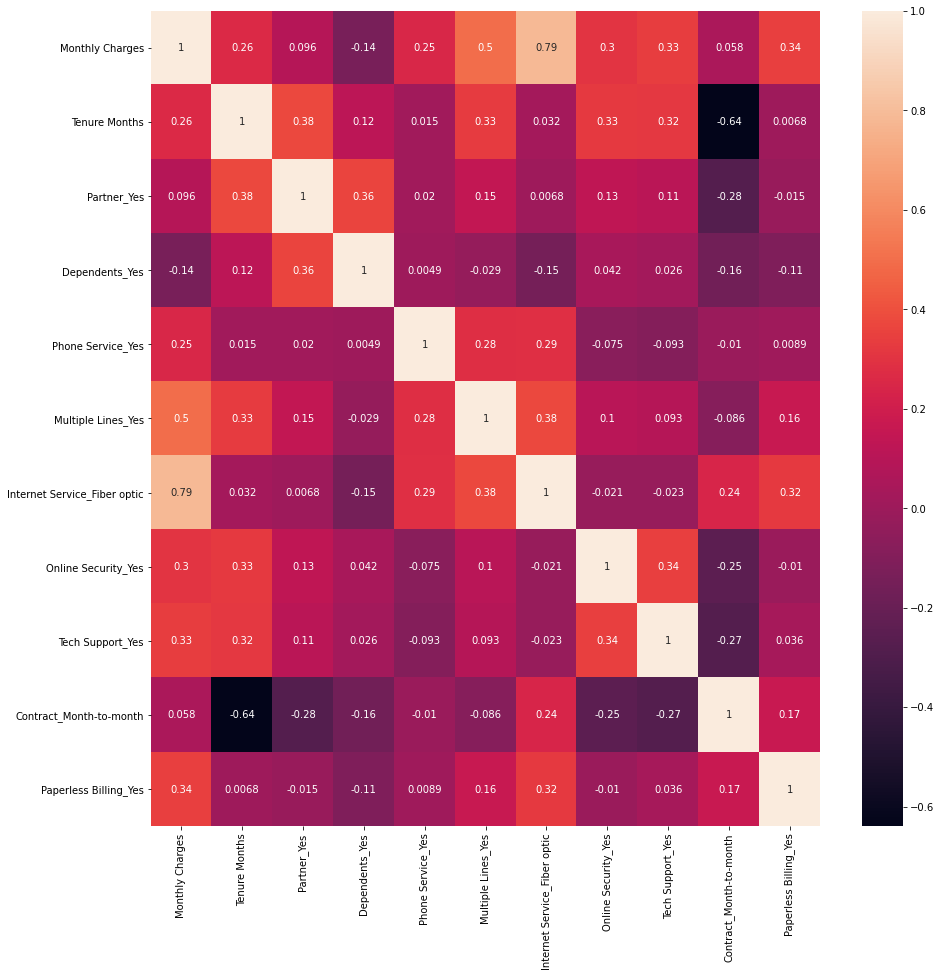

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(scaled_X_train.corr(), annot = True)

# SVC

In [ ]:
# Kernel - 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'
# gamma : {'scale', 'auto'} or float, optional (default='scale')  Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.
# C: A float

In [ ]:
feature_cols = list(scaled_X_train.columns)
feature_cols

['Monthly Charges',
 'Tenure Months',
 'Dependents_Yes',
 'Phone Service_Yes',
 'Multiple Lines_Yes',
 'Internet Service_Fiber optic',
 'Online Security_Yes',
 'Tech Support_Yes',
 'Contract_Month-to-month',
 'Paperless Billing_Yes']

## GridSearch Linear kernel

In [ ]:
#this is just for reference and syntax
#tuned_parameters = [{'kernel': ['rbf','poly','sigmoid'], 'gamma': [1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 'auto'],'C': [1, 10, 100, 1000, 10000]}]

In [ ]:
# creating list of parameter values
GS_lin_tuned_parameters = [{'kernel': ['linear'], 'C': [0.01, 0.1, 1, 10, 20, 30, 40, 50, 100, 1000]}]

In [ ]:
# creating GridSearch
GS_lin_train = GridSearchCV(SVC(), GS_lin_tuned_parameters, scoring='accuracy')

In [ ]:
#fitting best model
GS_lin_train.fit(scaled_X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, cache_size=None, class_weight=None, coef0=0.0,
                           decision_function_shape='ovo', degree=3,
                           gamma='auto', gpu_id=0, kernel='rbf', max_iter=-1,
                           max_mem_size=-1, n_jobs=-1, probability=False,
                           random_state=None, shrinking=False, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 20, 30, 40, 50, 100, 1000],
                          'kernel': ['linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [ ]:
#best model parameters
GS_lin_train.best_params_

{'C': 100, 'kernel': 'linear'}

In [ ]:
#train scores
print(classification_report(y_train, GS_lin_train.predict(scaled_X_train)))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      3903
           1       0.65      0.56      0.60      1379

    accuracy                           0.81      5282
   macro avg       0.75      0.73      0.74      5282
weighted avg       0.80      0.81      0.80      5282



In [ ]:
#test scores
print(classification_report(y_test, GS_lin_train.predict(scaled_X_test)))

              precision    recall  f1-score   support

           0       0.84      0.87      0.86      1271
           1       0.64      0.58      0.61       490

    accuracy                           0.79      1761
   macro avg       0.74      0.73      0.73      1761
weighted avg       0.79      0.79      0.79      1761



### Linear kernel

In [ ]:
#running best model from GridSearch alone
lin_train = SVC(kernel='linear', 
                C=100)

lin_train.fit(scaled_X_train, y_train)

SVC(C=100, cache_size=None, class_weight={}, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='auto', gpu_id=0,
    kernel='linear', max_iter=-1, max_mem_size=-1, n_jobs=-1, probability=False,
    random_state=None, shrinking=False, tol=0.001, verbose=False)

In [ ]:
#list of linear kernel coefficients
coef_list = list(lin_train.coef_[0][i] for i in range(len(lin_train.coef_[0])))
coefs = dict(zip(feature_cols, coef_list))


In [ ]:
#list of coefficients in increasing order of importance
a = sorted(coefs.items(), key=lambda x: abs(x[1]))    
a

[('Multiple Lines_Yes', -0.16364715993404388),
 ('Contract_Month-to-month', -0.3701300024986267),
 ('Tech Support_Yes', 0.39325717091560364),
 ('Online Security_Yes', 0.5452601313591003),
 ('Internet Service_Fiber optic', -0.8417264223098755),
 ('Phone Service_Yes', 1.0315361022949219),
 ('Dependents_Yes', 1.134164810180664),
 ('Monthly Charges', -1.631198525428772),
 ('Tenure Months', 2.558936834335327)]

In [ ]:
#train scores
apr(y_train, lin_train.predict(scaled_X_train))

Accuracy:0.8055660734570238
Precision:0.6476510067114094
Recall:0.5598259608411893
F1:0.6005445352003111


(0.8055660734570238,
 0.6476510067114094,
 0.5598259608411893,
 0.6005445352003111)

In [ ]:
#predicting y values for test
X_test['Pred_Y'] = lin_train.predict(scaled_X_test)

In [ ]:
#test scores
apr(y_test, lin_train.predict(scaled_X_test))

Accuracy:0.7921635434412265
Precision:0.6396396396396397
Recall:0.5795918367346938
F1:0.60813704496788


(0.7921635434412265, 0.6396396396396397, 0.5795918367346938, 0.60813704496788)

## GridSearch Non-linear

In [ ]:
#this is just for reference and syntax
#tuned_parameters = [{'kernel': ['rbf','poly','sigmoid'], 'gamma': [1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 'auto'],'C': [1, 10, 100, 1000, 10000]}]

In [ ]:
# choosing list of parameter values
GS_tuned_parameters = [{'kernel': ['rbf','sigmoid'], 'gamma': ['auto','scale'],'C': [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]}]

In [ ]:
#creating GridSearch
GS_train = GridSearchCV(SVC(), GS_tuned_parameters, scoring='accuracy')

In [ ]:
#fitting all combinations of parameters
GS_train.fit(scaled_X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, cache_size=None, class_weight=None, coef0=0.0,
                           decision_function_shape='ovo', degree=3,
                           gamma='auto', gpu_id=0, kernel='rbf', max_iter=-1,
                           max_mem_size=-1, n_jobs=-1, probability=False,
                           random_state=None, shrinking=False, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
                          'gamma': ['auto', 'scale'],
                          'kernel': ['rbf', 'sigmoid']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [ ]:
#best model parameters
GS_train.best_params_

{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}

In [ ]:
#train scores
print(classification_report(y_train, GS_train.predict(scaled_X_train)))

              precision    recall  f1-score   support

           0       0.85      0.90      0.88      3903
           1       0.67      0.54      0.60      1379

    accuracy                           0.81      5282
   macro avg       0.76      0.72      0.74      5282
weighted avg       0.80      0.81      0.80      5282



In [ ]:
#test scores
print(classification_report(y_test, GS_train.predict(scaled_X_test)))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1271
           1       0.66      0.56      0.61       490

    accuracy                           0.80      1761
   macro avg       0.75      0.72      0.73      1761
weighted avg       0.79      0.80      0.79      1761



### Non-linear kernel

In [ ]:
#running best model from GridSearch alone
train = SVC(gamma='auto'
              , kernel='rbf'
              , C=10
              , probability = True)

train.fit(scaled_X_train, y_train)

SVC(C=10, cache_size=None, class_weight={}, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='auto', gpu_id=0,
    kernel='rbf', max_iter=-1, max_mem_size=-1, n_jobs=-1, probability=True,
    random_state=None, shrinking=False, tol=0.001, verbose=False)

In [ ]:
#train scores
apr(y_train, train.predict(scaled_X_train))

Accuracy:0.8131389625141991
Precision:0.6956087824351297
Recall:0.5054387237128354
F1:0.5854682906341874


(0.8131389625141991,
 0.6956087824351297,
 0.5054387237128354,
 0.5854682906341874)

In [ ]:
#predicting test y values
X_test['Pred_Y'] = train.predict(scaled_X_test)

In [ ]:
#test scores
apr(y_test, train.predict(scaled_X_test))

Accuracy:0.8018171493469619
Precision:0.6860158311345647
Recall:0.5306122448979592
F1:0.5983889528193326


(0.8018171493469619,
 0.6860158311345647,
 0.5306122448979592,
 0.5983889528193326)

### Permutation importance

In [ ]:
# calculating feature importances
perm_importance = permutation_importance(train, scaled_X_train, y_train)

In [ ]:
features = np.array(feature_cols)

Text(0.5, 0, 'Permutation Importance')

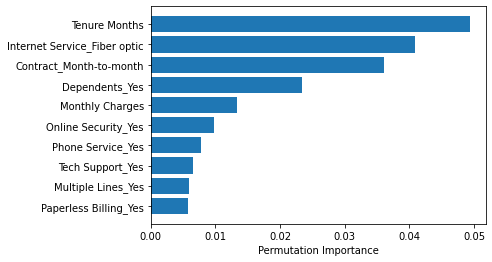

In [ ]:
#plotting feature importances
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

# Trying predict_proba

In [ ]:
# importing original data
myDF = pd.read_excel('customer_churn.xlsx', header = 0)

In [ ]:
churn = myDF.copy()
#removing useless columns
try:
    churn.drop(columns = ['Churn Label','CustomerID', 'Count', 'Country', 'State','City','Lat Long', 'Latitude', 'Longitude', 'Churn Reason'], inplace = True)
except:
    print('Already dropped!')

In [ ]:
# applying scaler
loyal = churn[churn['Churn Value'] == 0]
loyal_eng = feature_eng(loyal)

loyal_cols = list(loyal_eng.columns)
    
scaled_loyal_eng = scaler.transform(loyal_eng)
scaled_loyal_eng = pd.DataFrame(scaled_loyal_eng, columns= loyal_cols)
    
scaled_loyal_eng.set_index(loyal_eng.reset_index()['index'], inplace = True)

scaled_loyal_eng

,Monthly Charges,Tenure Months,Dependents_Yes,Phone Service_Yes,Multiple Lines_Yes,Internet Service_Fiber optic,Online Security_Yes,Tech Support_Yes,Contract_Month-to-month,Paperless Billing_Yes
index,,,,,,,,,,
1869,0.115423,0.013889,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1870,0.385075,0.472222,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1871,0.239303,0.625000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1872,0.704975,0.305556,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
1873,0.114428,0.138889,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
7038,0.028856,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
7039,0.662189,0.333333,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0
7040,0.845274,1.000000,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0


In [ ]:
#adding back CustomerID to the dataframe
loyal_id = myDF['CustomerID'][myDF['Churn Value'] == 0]
test = scaled_loyal_eng.join(loyal_id)
test.sort_values('Churn Probability', ascending= False, inplace = True)

In [ ]:
#list of top 500 by churn risk
churn_list = test[['CustomerID', 'Churn Probability']].head(500)
churn_list

,CustomerID,Churn Probability
index,,
4198,5150-ITWWB,0.868289
3732,4927-WWOOZ,0.864309
5906,4912-PIGUY,0.849819
1933,4445-ZJNMU,0.846769
1889,4929-XIHVW,0.843610
...,...,...
2798,4741-WWJQZ,0.445924
6551,8778-LMWTJ,0.445871
2156,8782-LKFPK,0.445247


In [ ]:
#save list as csv file
churn_list.to_csv('SVM_top_500.csv', index = False)